## To run this notebook locally and edit the plots, please download the following files:

lyotLib from the ucomp-configuration/Docs git repository and the lyot filter tuning ini files from the ucomp-configuration/config git repository.  You will also need to edit the gitDirectory variable in the lyotLib.ipynb file to match the local location of the ini files.

In [9]:
import numpy as np
import matplotlib.pylab as plt
from pathlib import Path
%run lyotLib.ipynb  # %run seems to be the jupyter notebook method for a relative path import.  This command will import the createStages and getFilterConfig functions

### Birefringent filters

Lyot filters are built in stages in which a single stage is configured with two linear polarizers mounted with their polarization axis at 0 degrees.  Sandwiched between these polarizers is a birefringent crystal with its fast and slow axes oriented at + and - 45 degrees to the polarizers.   


When an unpolarized beam of light is projected through one of these stages, the first polarizer acts as an input control, ensuring ½ of the light goes down each fast and slow axis.  The second polarizer acts as an analyzer. If the path length of the two axes is different by an exact wavelength multiple, it will produce constructive inteference and allow 100% of the signal to pass.  However, if the path length is some multiple of the wavelength +½ of the wavelength, the light will complete destructive interference at the analyzer, and no signal will get through.  

Since this path length change is proportional to the physical thickness of the crystal in the stage, it acts like a periodic filter that can be locally approximated as a cosine function.   To demonstrate this behavior (and other interesting features of the ucomp lyot filter), we have built the createStages function, which will allow us to explore the filter response.

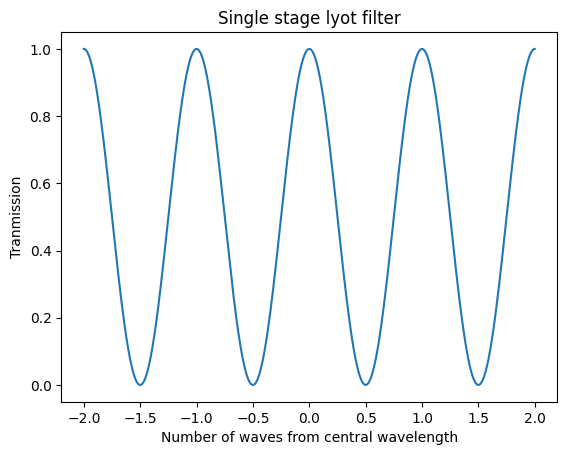

In [20]:
# stages defines the number of stages to include in the simulation.  (default = 5)
# width defines the number of cosine functions to display (default = 1)
fig, ax = plt.subplots()
ax.plot(*createStages(stages=1,width=4))
ax.set_title('Single stage lyot filter')
ax.set(ylabel="Tranmission",xlabel="Number of waves from central wavelength")
print("") #supress output from ax.set

If we double the crystal thickness, we end up with a crystal in which the interference cosine function has twice the frequency.  If we then chain these two stages together, with the output of the first stage becoming the input of the second, this mathematically acts like multiplying two cosine functions together.   For the createStages code, we can convert the cosine function to physical length units by specifying the Free Spectral Range (FSR) of a crystal in the filterConfig dictionary.

We can see in the plots below that the thicker crystal with ½ the FSR has peaks and nulls at twice the frequency as the narrow crystal.  When combined, every other peak constructively and destructively interferes, leaving us with a narrower central peak and less transmission in the wings. 


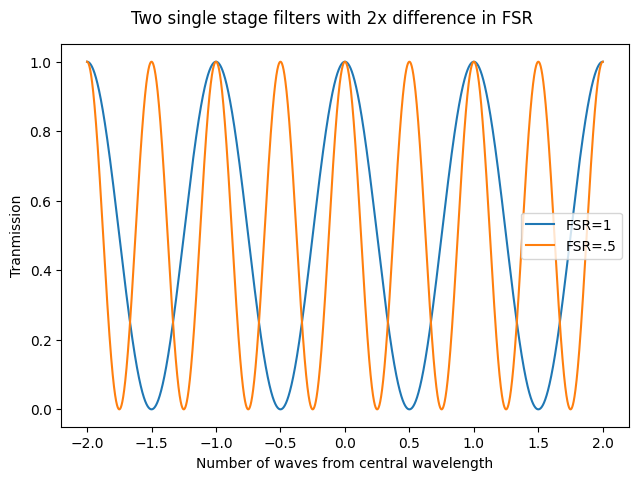

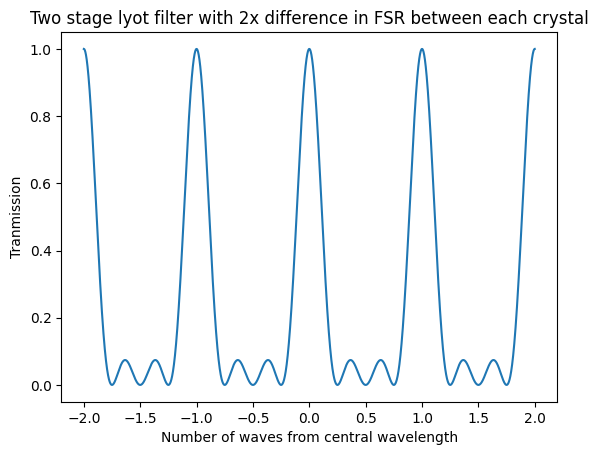

In [18]:
#  filterConfig is a dictionary that holds all the information needed for wavelength tunings.
#      here we are only setting the FSR and leaving everything else to default.
#
fig, ax = plt.subplots()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
ax.plot(*createStages(stages=1,width=4,filterConfig={"FSR":1}),label="FSR=1")
ax.plot(*createStages(stages=1,width=8,filterConfig={"FSR":.5}),label="FSR=.5")
fig.suptitle('Two single stage filters with 2x difference in FSR ')
ax.set(ylabel="Tranmission",xlabel="Number of waves from central wavelength")
ax.legend()


fig, ax = plt.subplots()
ax.plot(*createStages(stages=2,width=4))
ax.set_title('Two stage lyot filter with 2x difference in FSR between each crystal')
ax.set(ylabel="Tranmission",xlabel="Number of waves from central wavelength")
print("") #supress output from ax.set


If we add more stages with double the thickness of the next smallest crystal, we will create increasingly narrow central peak while reducing the transmission in the wings.  For example, with the 5 stage UCoMP lyot filter, we get a much sharper emission peak.  Here we have zoomed in to just focus on the shape of the central peak, but like the plots shown above, this is a peroidic filter that rings to infinity repeating this pattern in either direction.  

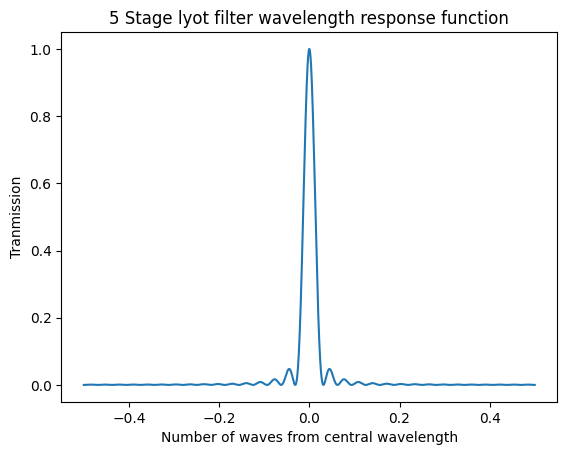

In [21]:

fig, ax = plt.subplots()
ax.plot(*createStages())
ax.set_title('5 Stage lyot filter wavelength response function')
ax.set(ylabel="Tranmission",xlabel="Number of waves from central wavelength")
print("")  #supress output from ax.set


At this point, we have developed the ability to produce very narrow wavelength filters, only depending on our precision machining crystals. Unfortunately, it is hard to get crystal thickness machined to wavelength fractions, and the filter response is fixed in the machine shop.

Suppose we insert a Liquid Crystal Variable Retarder (LCVR) behind the birefringent crystal.  We can use the LCVR to add path length to one axis.  By adjusting the voltages sent to the LCVR, we can change the retardance of the whole stage and effectively change the path length of the stage.    Adding an LCVR gives us two powerful things; first, we only have to get the crystals cut flat and close to the needed thickness, saving complex machining; second, we can now tune the bandpass of the filter at the telescope.

Below is an example of our tuning changes in our three wavelength waves program in UCoMP.




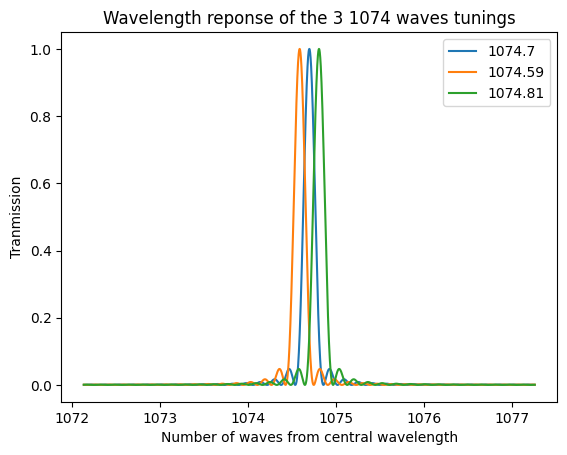

In [13]:
#getFilterConfig (defined in lyotLib.ipynb) reads the tuning file for FSR and region settings.
#wavelength defines where in the wave region to draw the emission line

filterConfig1074 = getFilterConfig("tuning_calibration_1074.7.ini")

fig, ax = plt.subplots()
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.7),label="1074.7")
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.59),label="1074.59")
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.81),label="1074.81")
ax.set_title('Wavelength reponse of the 3 1074 waves tunings')
ax.set(ylabel="Tranmission",xlabel="Number of waves from central wavelength")
ax.legend()

To calibrate the intensity of measurements we take in UCoMP, we make measurements of both the coronal emission line and the continuum from a nearby region of the spectrum. Given our ability to vary the measurement wavelength, we could access the continuum by re-tuning the filter and taking another data set. However, we would like to measure the continuum simultaneously with the coronal signal. If we rotate the analyzer polarizer by 90 degrees, we are now looking at light that effectively has a pi/2 phase shift in the crystals. This changes the location of the peaks and nulls by a phase of pi/2. This effectively means we are probing an area 1/2 an FSR away from the central wavelength on both sides. With a polarizing beamsplitter replacing the last analyzer, we are sending the central wavelength in one direction, and light with the pi/2 phase shift 90 degrees away. By placing a camera on both of these beams, we are able to measure the central wavelength and a continuum wavelength 1/2 an FSR away. 


To handle optical or other asymmetries between the throughput of two arms/cameras in UCoMP, we beam swap the central wavelength and continuum signals back and forth between the cameras while taking data. In the default configuration, the central emission line passes to the transmitted beam while the continuum is sent to the reflected beam. However, if we add a phase of pi/2 to the last crystal in the stack (2nd thinnest), the beams swap, sending the continuum to the transmitted beam, and the central emission peak to the reflected beam.


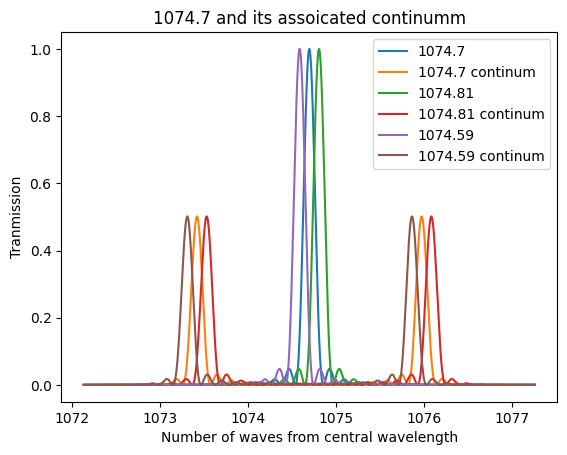

In [14]:
filterConfig1074 = getFilterConfig("tuning_calibration_1074.7.ini")

# cam defines if a pi/2 phase shift should be applied to the second stage to switch between the emisison line and conintum
#    default value is "onband" which does not apply the shift
fig, ax = plt.subplots()
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.7),label="1074.7")
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.7,cam="offband"),label="1074.7 continuum")
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.81),label="1074.81")
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.81,cam="offband"),label="1074.81 continuum")
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.59),label="1074.59")
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.59,cam="offband"),label="1074.59 continuum")
ax.set_title('1074.7 and its assoicated continuum')
ax.set(ylabel="Tranmission",xlabel="Number of waves from central wavelength")
ax.legend()

One drawback of having the continuum a fixed distance from the central wavelength; is that our continuum sampling may fall into a busy spectrum area with strong emission or absorption lines. To mitigate the effects of this, we can change the continuum sampling from being 50/50 on the red and blue side of the central wavelength to an 85/15 split bias to either the red or blue wings.  

To implement this red or blue biasing, a pi/8 phase shift is added (or subtracted) from stage0.

Giving the following results:

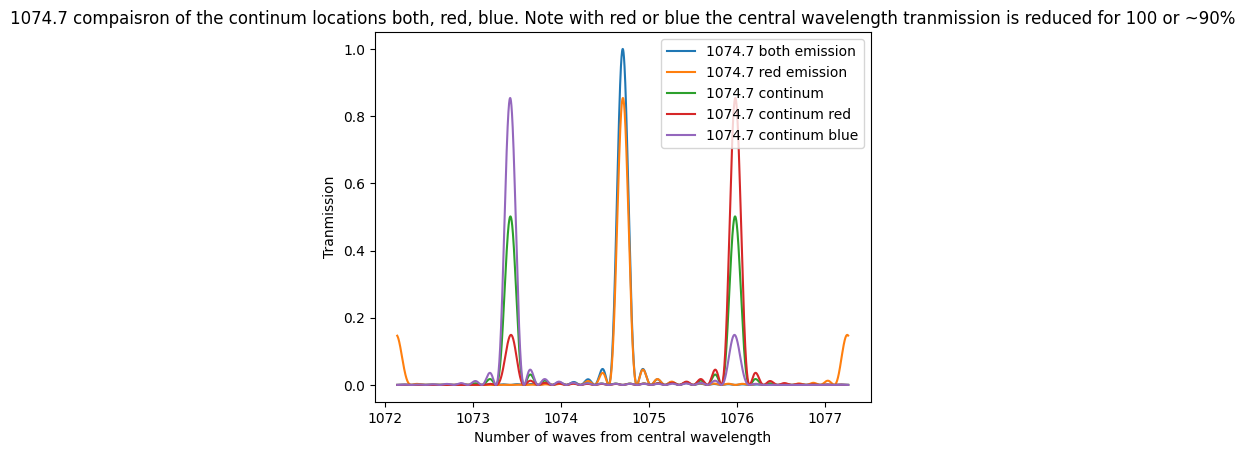

In [15]:
filterConfig1074 = getFilterConfig("tuning_calibration_1074.7.ini")

# cam defines if a (+/-) pi/8 phase shift should be applied to the first  stage to switch between 50/50, 85/15 and 15/85 red vs blue continumm
fig, ax = plt.subplots()
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.7),label="1074.7 both emission")
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.7,cont="red"),label="1074.7 red emission")
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.7,cam="offband"),label="1074.7 continuum")
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.7,cam="offband",cont="red"),label="1074.7 continuum red")
ax.plot(*createStages(filterConfig=filterConfig1074,wavelength=1074.7,cam="offband",cont="blue"),label="1074.7 continuum blue")
ax.set_title('1074.7 compaisron of the continuum locations both, red, blue. Note with red or blue the central wavelength tranmission is reduced for 100 or ~90%')
ax.set(ylabel="Tranmission",xlabel="Number of waves from central wavelength")
ax.legend()

The UCoMP lyot filter is based on lithium niobate crystals; these lab-grown crystals offer large clear apertures and can be made with uniform properties in much larger physical sizes than the calcite crystals typically used on lyot filters. The one major drawback of these crystals is the birefringence of the crystal has a strong temperature coefficient. A tenth-of-a-degree change in the crystals completely throws off the calibrations. To account for this, we actively heat the instrument box to ~33C and the filter to 35C with thermal blankets and a high-precision thermal control system. We also attached a milidegree thermometer to each crystal to monitor the actual temperature of each crystal and added phase offsets to the filter to account for any changes the crystal sees vs. the lab measurements when the filter was characterized.

If just one crystal drifts, we can get a change in transmission location and intensity. 

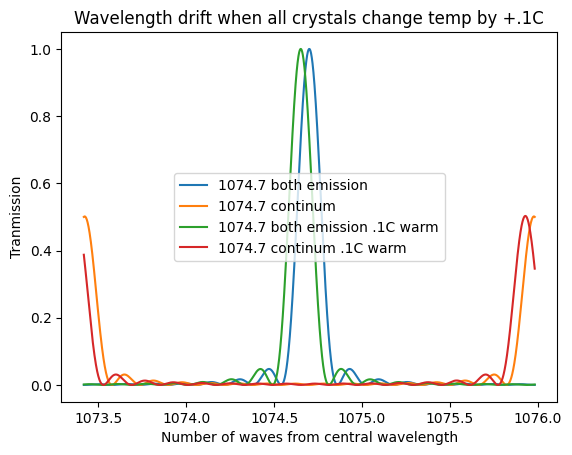

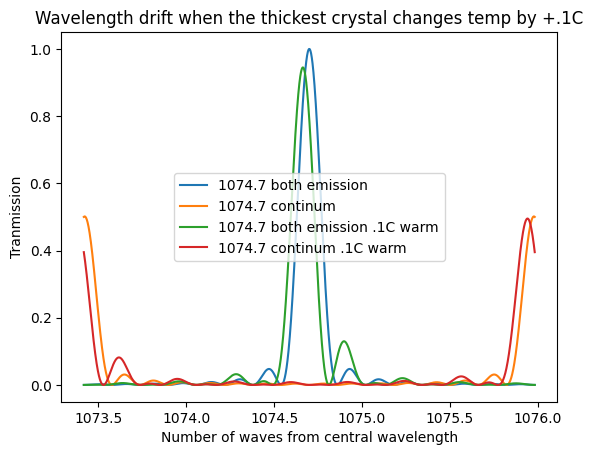

In [16]:
filterConfig1074 = getFilterConfig("tuning_calibration_1074.7.ini")


# tempCof is a list of lab measured tempature correction coefficents that are applied to correct the phase as the tempature vareis in the following way:
#corrected phase[stageNum] = uncorrected phase[stageNum] - tempCof[stageNum]*(measured Temp[stageNum]- tempRef[stageNum])
# Since we are stating a .1 degree change from the lab measrued reference tempature  we set out offsets to be .1*tempCof
offsets = np.array(filterConfig1074["tempCof"])*.1

fig, ax = plt.subplots()
ax.plot(*createStages(width=.5,filterConfig=filterConfig1074,wavelength=1074.7),label="1074.7 both emission")
ax.plot(*createStages(width=.5,filterConfig=filterConfig1074,wavelength=1074.7,cam="offband"),label="1074.7 continuum")
ax.plot(*createStages(width=.5,filterConfig=filterConfig1074,wavelength=1074.7,offsets=offsets),label="1074.7 both emission .1C warm")
ax.plot(*createStages(width=.5,filterConfig=filterConfig1074,wavelength=1074.7,offsets=offsets,cam="offband"),label="1074.7 continuum .1C warm")
ax.set_title('Wavelength drift when all crystals change temp by +.1C')
ax.set(ylabel="Tranmission",xlabel="Number of waves from central wavelength")
ax.legend()


# To demonstrate the effect of the thick crystal being warm all other tempatures offsets are set t o0.
offsets = [0,0,0,0,np.array(filterConfig1074["tempCof"])[4]*.1]

fig, ax = plt.subplots()
ax.plot(*createStages(width=.5,filterConfig=filterConfig1074,wavelength=1074.7),label="1074.7 both emission")
ax.plot(*createStages(width=.5,filterConfig=filterConfig1074,wavelength=1074.7,cam="offband"),label="1074.7 continuum")
ax.plot(*createStages(width=.5,filterConfig=filterConfig1074,wavelength=1074.7,offsets=offsets),label="1074.7 both emission .1C warm")
ax.plot(*createStages(width=.5,filterConfig=filterConfig1074,wavelength=1074.7,offsets=offsets,cam="offband"),label="1074.7 continuum .1C warm")
ax.set_title('Wavelength drift when the thickest crystal changes temp by +.1C')
ax.set(ylabel="Tranmission",xlabel="Number of waves from central wavelength")
ax.legend()
